In [9]:
import finesse
from finesse.components import Laser, Lens, Mirror, Nothing, Space, Cavity
import matplotlib.pyplot as plt
import numpy as np
from scipy.integrate import quad

from PIL import Image
from pathlib import Path
from pprint import pprint
from itertools import zip_longest

W_UPPER_BOUND = (2**0.5)*(1e-3)/4
W_REAL = 200e-6
q_i = finesse.gaussian.BeamParam(wavelength=1550e-9, w0=W_UPPER_BOUND,z=0)

In [2]:
def setup_optics(n_mirrors, cavity_length):
    M = finesse.model.Model()
    M.lambda0 = 1550e-9

    start = Laser("L_1550", P=1, f=(300e6)/(1550e-9))
    mirrors = [Lens(f"m{n}", f=0.5) for n in range(0, n_mirrors)]
    M.add([start, *mirrors])
    
    s_start_m0 = Space("s_start_m0", portA=start.p1, portB=mirrors[0].p1, L=cavity_length/2)
    M.add(s_start_m0)
   
    ports = M.get_open_ports()
    spaces = [Space(f"s_m{n}", portA=ports[n], portB=ports[n+1], L=cavity_length) for n in range(0, 2*(n_mirrors-1), 2)]
    M.add(spaces)
    
    return M

In [3]:
M = setup_optics(12, 0.15)

○ L_1550
╰──○ m0 (L_1550.p1 ↔ m0.p1)
   ╰──○ m1 (m0.p2 ↔ m1.p1)
      ╰──○ m2 (m1.p2 ↔ m2.p1)
         ╰──○ m3 (m2.p2 ↔ m3.p1)
            ╰──○ m4 (m3.p2 ↔ m4.p1)
               ╰──○ m5 (m4.p2 ↔ m5.p1)
                  ╰──○ m6 (m5.p2 ↔ m6.p1)
                     ╰──○ m7 (m6.p2 ↔ m7.p1)
                        ╰──○ m8 (m7.p2 ↔ m8.p1)
                           ╰──○ m9 (m8.p2 ↔ m9.p1)
                              ╰──○ m10 (m9.p2 ↔ m10.p1)
                                 ╰──○ m11 (m10.p2 ↔ m11.p1)


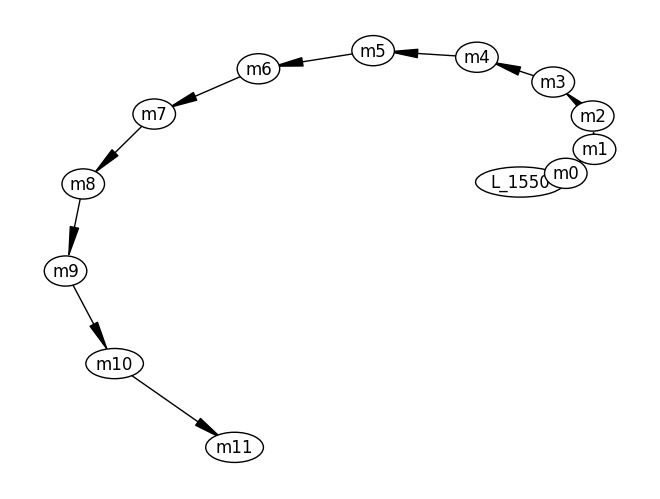

In [4]:
print(M.component_tree(show_ports=True))
M.plot_graph(graphviz=False, arrows=True, layout="spiral")


In [5]:
#cavity_lengths = [0.25, 0.5, 0.75, 1.0, 1.25, 1.5, 1.75, 2.0]
#cavity_lengths = [0.05, 0.1, 0.15, 0.2, 0.25]
cavity_lengths = [0.14, 0.15, 0.16]

nodes = M.optical_nodes
beam_path = M.path(nodes[1], nodes[-1])
spaces = M.get_elements_of_type(Space)

sim = M.propagate_beam(path=beam_path, q_in=q_i, symbolic=tuple([space.L for space in spaces]),)
#sim = M.propagate_beam(path=beam_path, q_in=q_i)
#sim.plot("beamsize", single_sided=True, show=True, ylims=(0.365, 0.4), ignore=M.get_elements_of_type(Lens))

#fig, ax, anim = sim.animate({spaces[0].L: [L/2 for L in cavity_lengths]} | {space.L: cavity_lengths for space in spaces[1:]}, "beamsize", show=False)

┌─────────────╥─────────┬───────────┬───────────┬───────────┬────────────┬────────────┬───────────┬─────────────────┐
│             ║    z    │    w0     │    zr     │     w     │    RoC     │     S      │ Acc. Gouy │        q        │
╞═════════════╬═════════╪═══════════╪═══════════╪═══════════╪════════════╪════════════╪═══════════╪═════════════════╡
│ L_1550.p1.o ║     0 m │    200 um │ 81.073 mm │    200 um │      inf m │        0 D │        0° │  0.000 + 0.081j │
├─────────────╫─────────┼───────────┼───────────┼───────────┼────────────┼────────────┼───────────┼─────────────────┤
│   m0.p1.i   ║   75 mm │    200 um │ 81.073 mm │ 272.45 um │  162.64 mm │   6.1486 D │   42.772° │  0.075 + 0.081j │
├─────────────╫─────────┼───────────┼───────────┼───────────┼────────────┼────────────┼───────────┼─────────────────┤
│   m0.p2.o   ║   75 mm │ 231.13 um │ 108.27 mm │ 272.45 um │  241.04 mm │   4.1486 D │   42.772° │  0.068 + 0.108j │
├─────────────╫─────────┼───────────┼───────────┼───────

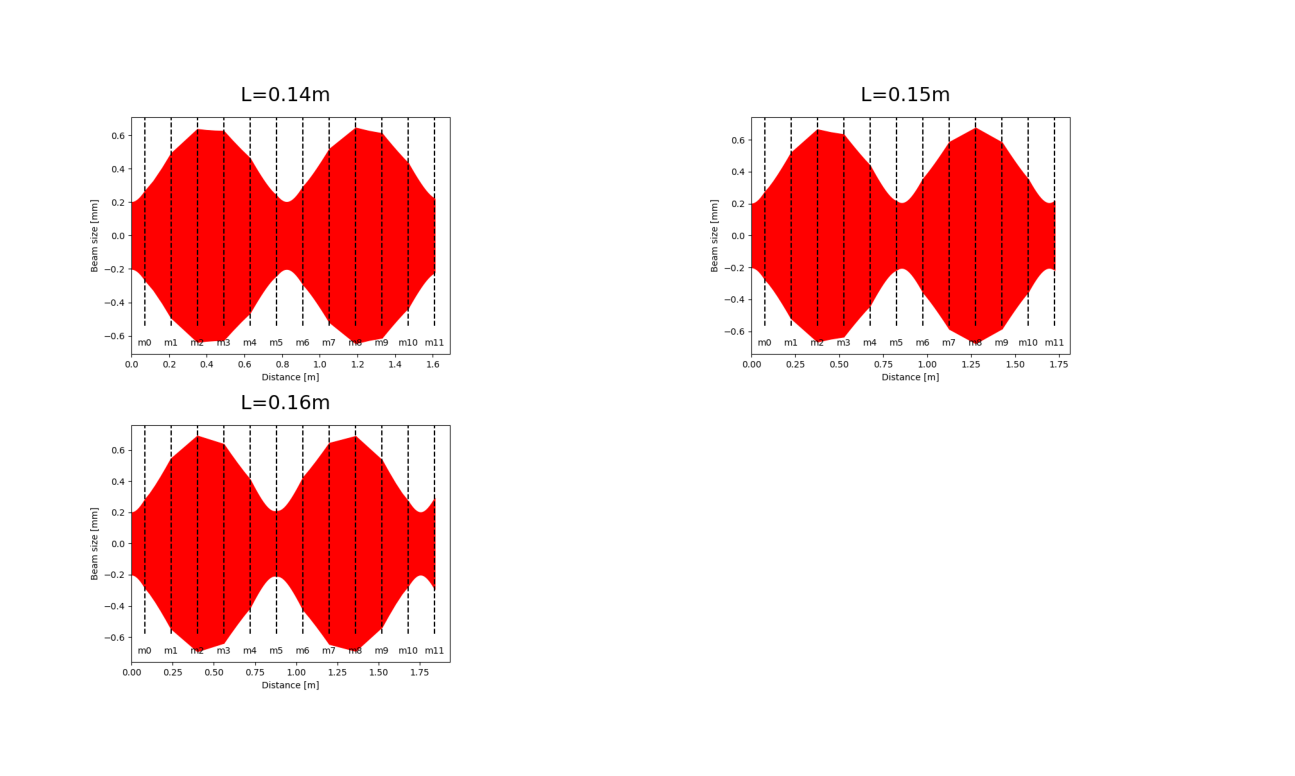

'\nfrom IPython.display import HTML\nHTML(anim.to_jshtml())\n'

In [6]:
plt.rcParams["animation.html"] = "jshtml"


# A LOT OF THIS STUFF IS JUST TO SAVE THE IMAGES SO WE CAN DISPLAY THEM HERE IN A PRETTY WAY... #

figs = []
axs = []
for length in cavity_lengths:
    fig, ax = sim.plot("beamsize", single_sided=False, show=False,  subs={spaces[0].L: length/2} | {space.L: length for space in spaces[1:]},)
    if length == 0.15: print(sim)
    fig.suptitle(rf"L={length}m", fontsize=22)
    fig.savefig(f"TEMP{length}.png", pad_inches=0,)# facecolor="green")
    axs.append(ax)
    plt.close()

imgs = [np.asarray(Image.open(f"TEMP{n}.png")) for n in cavity_lengths]

fs, axes = plt.subplots(ncols=2, nrows=(len(axs)+1)//2, figsize=(2, (len(axs))//2), dpi=800)

for ax, img in zip_longest(axes.flatten(), imgs, fillvalue=[]):
    ax.axis("off")
    if len(img) == 0: break;
    ax.imshow(img)
    
fs.subplots_adjust(wspace=0, hspace=0, )
fs.savefig(f"cav_lengths_{cavity_lengths[0]}_{cavity_lengths[-1]}.png")

for p in Path(".").glob("TEMP*.png"):
    p.unlink()

plt.show(fs)

"""
from IPython.display import HTML
HTML(anim.to_jshtml())
"""

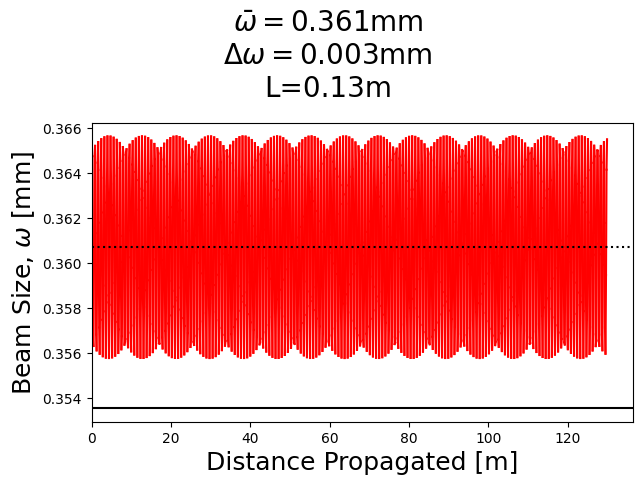

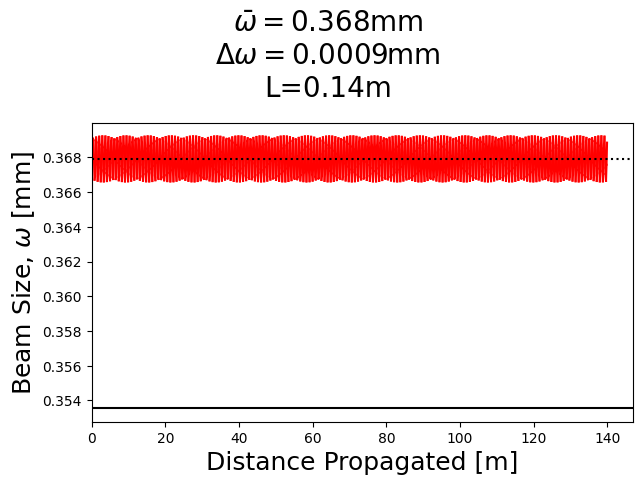

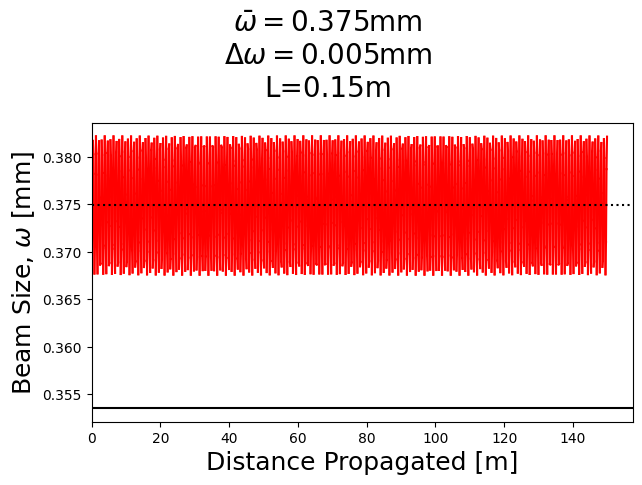

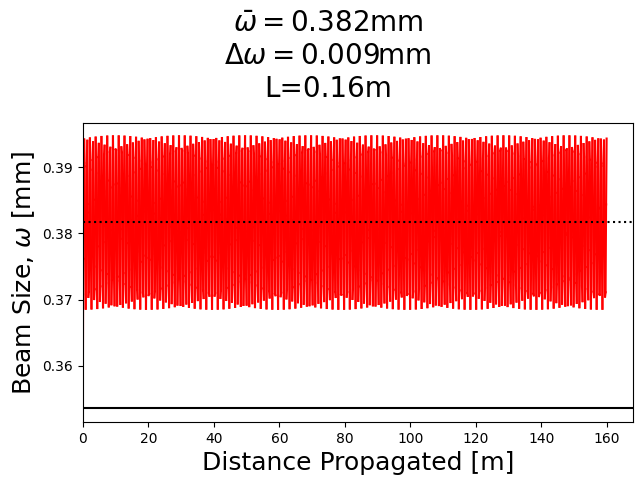

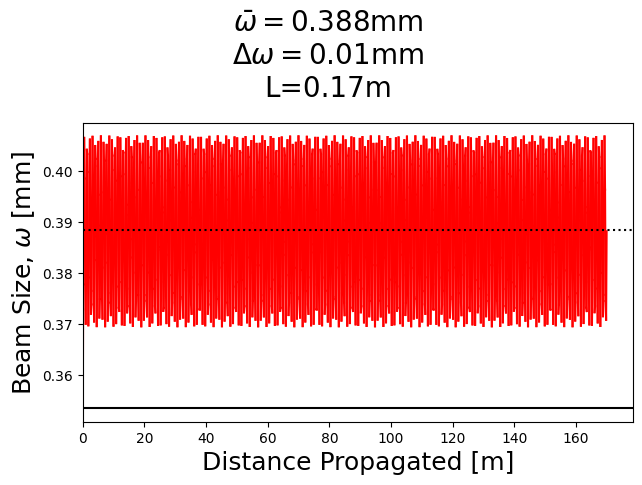

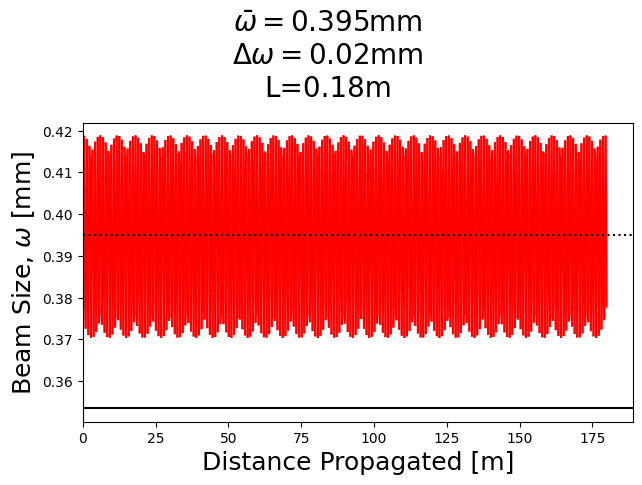

In [17]:
from math import floor, log10
def round_sig(x, sig=3):
    return round(x, sig-int(floor(log10(abs(x))))-1)
sims = []
Ls = [0.13, 0.14, 0.15, 0.16, 0.17, 0.18]
for L in Ls:
    
    M = setup_optics(1000, L)
    nodes = M.optical_nodes
    beam_path = M.path(nodes[1], nodes[-1])
    sim = M.propagate_beam(path=beam_path, q_in=q_i)
    
    f, a = sim.plot("beamsize", ignore=M.get_elements_of_type(Lens), single_sided=True)


    

    ws = [sim.q(m).w for m in nodes[2:-1:2]]
    mean = np.mean(ws)
    std = np.std(ws)
    #print(" L =", L, "\t", "w_mean: ", np.mean(ws), " w_std:", np.std(ws))

    padding = std*3
    #a.set_ylim((1e3)*(np.mean(ws)- padding), (1e3)*(np.mean(ws)+padding))
    a.hlines(y=(mean*1e3),xmin=a.get_xlim()[0], xmax=a.get_xlim()[1], color="black", linestyle="dotted")
    a.hlines(y=W_UPPER_BOUND*1e3,xmin=a.get_xlim()[0], xmax=a.get_xlim()[1], color="black", linestyle="solid")
    plt.suptitle(r"$\bar{\omega}=$"+str(round_sig(mean*1e3,3))+"mm\n"+ r"$\Delta\omega=$"+str(round_sig(std*1e3,1))+"mm\n"+f"L={L}m", fontsize=20)
    plt.tight_layout()
    plt.savefig(f"L={L}m.png")
    a.set_ylabel(r"Beam Size, $\omega$ [mm]", fontsize=18)
    a.set_xlabel("Distance Propagated [m]", fontsize=18)

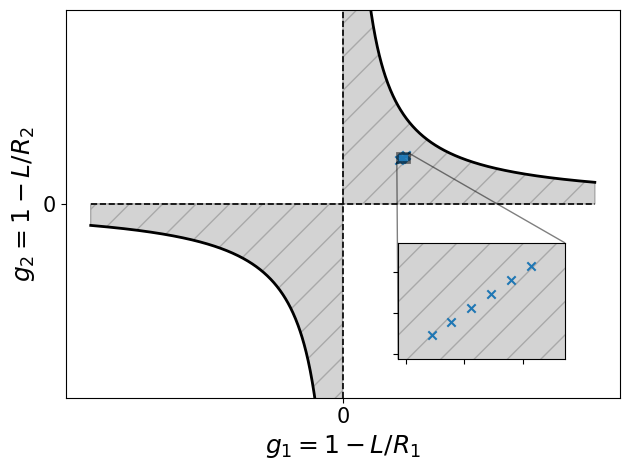

In [8]:
limits = np.linspace(-3, 3, 1000)
p_xs = limits[limits > 0]
n_xs = limits[limits < 0]

    
def stability(L, R1, R2):
    return (1 - (L/R1))*(1 - (L/R2))

f, a = plt.subplots()
a.plot(p_xs,  1/p_xs, color="black", linewidth=2)
a.plot(n_xs, 1/n_xs, color="black", linewidth=2)

ver = a.vlines(x=0,ymin=limits[0],ymax=limits[-1],color="black",linewidth=1.2, linestyle='--')
hor = a.hlines(y=0,xmin=limits[0],xmax=limits[-1],color="black",linewidth=1.2, linestyle='--')

a.fill_between(p_xs, 1/p_xs, hatch='/', edgecolor="darkgray", facecolor="lightgray")
a.fill_between(n_xs, 1/n_xs, hatch='/', edgecolor="darkgray", facecolor="lightgray")
a.set_ylim(-3,3)
a.set_xlabel(r"$g_1 = 1 - L/R_1$", fontsize=18)
a.set_ylabel(r"$g_2 = 1 - L/R_2$", fontsize=18)
a.set_xticks([0], labels=[0], fontsize=15)
a.set_yticks([0], labels=[0], fontsize=15)

gs = [stability(L, 1, 1) for L in Ls]

del_g = np.std(gs)
a.scatter(gs, gs, marker='x')
x1 = y1 = min(gs) - del_g
x2 = y2 = max(gs) + del_g

inset = a.inset_axes(
    [0.6, 0.1, 0.3, 0.3],
    xlim=(x1, x2), ylim=(y1, y2), xticklabels=[], yticklabels=[])

a.indicate_inset_zoom(inset, edgecolor="black", linewidth=2)

inset.plot(p_xs,  1/p_xs, color="black", linewidth=2)
inset.fill_between(p_xs, 1/p_xs, hatch='/', edgecolor="darkgray", facecolor="lightgray")
inset.scatter(gs, gs, marker='x',)

plt.tight_layout()
plt.savefig("stability.png",dpi=300)